<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Machine%20Learning/Regression_Models_with_Decision_Tree%2C_Random_Forest_and_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uzazam","key":"7abb2778b77e603b3a87069f481fc6a6"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change the permission

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d florianlandras/stockholm-house-market-prices

  0% 0.00/22.9k [00:00<?, ?B/s]
100% 22.9k/22.9k [00:00<00:00, 19.7MB/s]


In [5]:
from zipfile import ZipFile
file_name = "/content/stockholm-house-market-prices.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [61]:
df = pd.read_csv('/content/hemnet_data_clean.csv')
df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
df.head()

,address,asked_price,coordinate,final_price,pourcentage_difference,land_area,area,commune,price_per_area,rooms,sale_date,supplemental_area
0,Markviksvägen 15,6475000.0,"[59.371685, 17.8250389]",6950000,7.0,635.0,117.0,"Hässelby Södra Villastad, Stockholms kommun",59402.0,5.0,Såld 2022-06-17,44.0
1,Mälarhöjdsvägen 38,9950000.0,"[59.3008766, 17.9478054]",11300000,14.0,882.0,195.0,"Mälarhöjden - Hägersten, Stockholms kommun",57949.0,5.0,Såld 2022-06-17,22.0
2,Häradsvägen 202,5795000.0,"[59.27202322587505, 17.954076342308372]",6200000,7.0,1224.0,90.0,"Segeltorp, Huddinge kommun",68889.0,6.0,Såld 2022-06-17,90.0
3,Hemmansvägen 18,11950000.0,"[59.28390406370304, 18.07625832074728]",12700000,6.0,542.0,110.0,"Gamla Enskede, Stockholms kommun",115455.0,5.0,Såld 2022-06-17,48.0
4,Alholmsbacken 8,7950000.0,"[59.28134, 17.9009438]",8100000,2.0,690.0,157.0,"Skärholmshöjden., Stockholms kommun",51592.0,6.0,Såld 2022-06-17,0.0


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   address                 500 non-null    object 
 1   asked_price             500 non-null    float64
 2   coordinate              500 non-null    object 
 3   final_price             500 non-null    int64  
 4   pourcentage_difference  500 non-null    float64
 5   land_area               495 non-null    float64
 6   area                    499 non-null    float64
 7   commune                 500 non-null    object 
 8   price_per_area          499 non-null    float64
 9   rooms                   490 non-null    float64
 10  sale_date               500 non-null    object 
 11  supplemental_area       500 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 47.0+ KB


Converting Catagorical Variables

In [63]:
df_frequency_map = df.price_per_area.value_counts().to_dict()
df.zip_code = df.price_per_area.map(df_frequency_map)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,address,asked_price,coordinate,final_price,pourcentage_difference,land_area,area,commune,price_per_area,rooms,sale_date,supplemental_area
0,Markviksvägen 15,6475000.0,"[59.371685, 17.8250389]",6950000,7.0,635.0,117.0,"Hässelby Södra Villastad, Stockholms kommun",59402.0,5.0,Såld 2022-06-17,44.0
1,Mälarhöjdsvägen 38,9950000.0,"[59.3008766, 17.9478054]",11300000,14.0,882.0,195.0,"Mälarhöjden - Hägersten, Stockholms kommun",57949.0,5.0,Såld 2022-06-17,22.0
2,Häradsvägen 202,5795000.0,"[59.27202322587505, 17.954076342308372]",6200000,7.0,1224.0,90.0,"Segeltorp, Huddinge kommun",68889.0,6.0,Såld 2022-06-17,90.0
3,Hemmansvägen 18,11950000.0,"[59.28390406370304, 18.07625832074728]",12700000,6.0,542.0,110.0,"Gamla Enskede, Stockholms kommun",115455.0,5.0,Såld 2022-06-17,48.0
4,Alholmsbacken 8,7950000.0,"[59.28134, 17.9009438]",8100000,2.0,690.0,157.0,"Skärholmshöjden., Stockholms kommun",51592.0,6.0,Såld 2022-06-17,0.0


In [64]:
df_frequency_map2 = df.area.value_counts().to_dict()
df.city = df.area.map(df_frequency_map2)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,address,asked_price,coordinate,final_price,pourcentage_difference,land_area,area,commune,price_per_area,rooms,sale_date,supplemental_area
0,Markviksvägen 15,6475000.0,"[59.371685, 17.8250389]",6950000,7.0,635.0,117.0,"Hässelby Södra Villastad, Stockholms kommun",59402.0,5.0,Såld 2022-06-17,44.0
1,Mälarhöjdsvägen 38,9950000.0,"[59.3008766, 17.9478054]",11300000,14.0,882.0,195.0,"Mälarhöjden - Hägersten, Stockholms kommun",57949.0,5.0,Såld 2022-06-17,22.0
2,Häradsvägen 202,5795000.0,"[59.27202322587505, 17.954076342308372]",6200000,7.0,1224.0,90.0,"Segeltorp, Huddinge kommun",68889.0,6.0,Såld 2022-06-17,90.0
3,Hemmansvägen 18,11950000.0,"[59.28390406370304, 18.07625832074728]",12700000,6.0,542.0,110.0,"Gamla Enskede, Stockholms kommun",115455.0,5.0,Såld 2022-06-17,48.0
4,Alholmsbacken 8,7950000.0,"[59.28134, 17.9009438]",8100000,2.0,690.0,157.0,"Skärholmshöjden., Stockholms kommun",51592.0,6.0,Såld 2022-06-17,0.0


In [65]:
df.drop('address',axis=1,inplace=True)
df.drop('coordinate',axis=1,inplace=True)
df.drop('commune',axis=1,inplace=True)
df.drop('sale_date', axis = 1, inplace = True)

In [66]:
df.tail()

,asked_price,final_price,pourcentage_difference,land_area,area,price_per_area,rooms,supplemental_area
495,9500000.0,11760000,24.0,624.0,164.0,71707.0,8.0,70.0
496,7295000.0,7295000,0.0,618.0,125.0,58360.0,NaN,81.0
497,9795000.0,10200000,4.0,700.0,172.0,59302.0,6.0,36.0
498,11950000.0,13000000,9.0,1307.0,174.0,74713.0,8.0,90.0
499,12495000.0,15000000,20.0,691.0,137.0,109489.0,5.0,64.0


In [67]:
df.shape

(500, 8)

In [68]:
df.columns

Index(['asked_price', 'final_price', 'pourcentage_difference', 'land_area',
       'area', 'price_per_area', 'rooms', 'supplemental_area'],
      dtype='object')

Separating independent and dependent variable

In [72]:
X = df.drop('final_price', axis =1)
y = df['final_price']

In [78]:
X.isna().sum()

asked_price                0
pourcentage_difference     0
land_area                  5
area                       1
price_per_area             1
rooms                     10
supplemental_area          0
dtype: int64

In [79]:
X.fillna(method= 'ffill', inplace=True)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.4)

In [81]:
X_train.shape, y_train.shape

((300, 7), (300,))

In [82]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

Regression coefficients

In [83]:
print('Coefficients:', reg.coef_)

Coefficients: [ 1.00257358e+00  8.59818292e+04 -1.74210680e+00  7.47663131e+01
  4.20938964e+00  9.53225135e+03 -2.52418274e+03]


variance score: 1 means perfect prediction

In [84]:
print('Variance score: {}'.format(reg.score(X_test, y_test)))

Variance score: 0.9759180823649167


plot for residual error

In [85]:
plt.style.use('fivethirtyeight')

plotting residual errors in training data

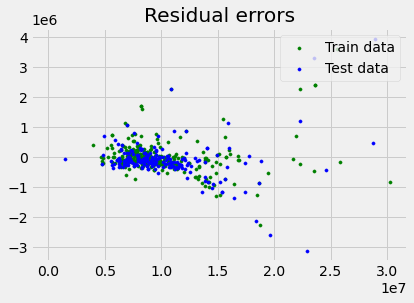

In [87]:
plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train,
            color = "green", s = 10, label = 'Train data')
  
## plotting residual errors in test data
plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test,
            color = "blue", s = 10, label = 'Test data')
  
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
  
## plotting legend
plt.legend(loc = 'upper right')
  
## plot title
plt.title("Residual errors")
  
## method call for showing the plot
plt.show()

Making predictions using the Decision Tree algorithm

In [88]:
decision_model = DecisionTreeRegressor()
decision_model.fit(X_train, y_train)
predicted_decision_trees = decision_model.predict(X_test)
print("Mean Absolute Error using Decision Trees:", mean_absolute_error(y_test, predicted_decision_trees))
print(decision_model.score(X_test, y_test))

Mean Absolute Error using Decision Trees: 431310.0
0.9651216577165026


Making predictions using the Random Forest algorithm

In [89]:
forest_model = RandomForestRegressor(n_estimators = 100, max_depth = 10)
forest_model.fit(X_train, y_train)
predicted_random_forest = forest_model.predict(X_test)
print("Mean Absolute Error using Random Forest:", mean_absolute_error(y_test, predicted_decision_trees)) 
print(forest_model.score(X_test, y_test))

Mean Absolute Error using Random Forest: 431310.0
0.9748834564046786


Making predictions using the XGBoost algorithm

In [90]:
xg_model = XGBRegressor(n_estimators = 100)
xg_model.fit(X_train, y_train)
predicted_XGBoost = xg_model.predict(X_test)

print("Mean Absolute Error using XGBoost:", mean_absolute_error(y_test, predicted_XGBoost))
print(xg_model.score(X_test, y_test))

[14:57:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error using XGBoost: 355064.725
0.9742582008290047
